<a href="https://colab.research.google.com/github/YongchangHu/Books/blob/master/85_SOM_color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

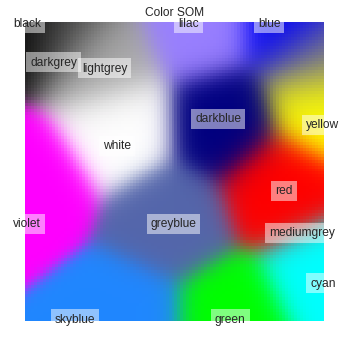

In [0]:
#For plotting the images
from matplotlib import pyplot as plt
import sys
import numpy as np
import tensorflow as tf
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from skimage.color import rgba2rgb

old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
np.random.seed(6278)

# SOM as layer
class SOM_Layer(): 

    def __init__(self,m,n,dim,learning_rate_som = 0.5,radius_factor = 1.3):
        
        self.m = m
        self.n = n
        self.dim = dim
        self.map = tf.Variable(tf.random_uniform(shape=[m*n,dim],minval=0,maxval=1,seed=2))
        self.location_vects = tf.constant(np.array(list(self._neuron_locations(m, n))))
        self.alpha = learning_rate_som
        self.sigma = max(m,n)*1.1

    def _neuron_locations(self, m, n):
        """
        Yields one by one the 2-D locations of the individual neurons in the SOM.
        """
        # Nested iterations over both dimensions to generate all 2-D locations in the map
        for i in range(m):
            for j in range(n):
                yield np.array([i, j])

    def getmap(self): return self.map
    def getlocation(self): return self.bmu_locs

    def feedforward(self,input):
    
        self.input = input
        self.squared_distance = tf.reduce_sum(tf.pow(tf.subtract(tf.expand_dims(self.map, axis=0),tf.expand_dims(self.input, axis=1)), 2), 2)
        self.bmu_indices = tf.argmin(self.squared_distance, axis=1)
        self.bmu_locs = tf.reshape(tf.gather(self.location_vects, self.bmu_indices), [-1, 2])

    def backprop(self,iter,num_epoch):

        # Update the weigths 
        radius = tf.subtract(self.sigma,
                                tf.multiply(iter,
                                            tf.divide(tf.cast(tf.subtract(self.alpha, 1),tf.float32),
                                                    tf.cast(tf.subtract(num_epoch, 1),tf.float32))))

        alpha = tf.subtract(self.alpha,
                            tf.multiply(iter,
                                            tf.divide(tf.cast(tf.subtract(self.alpha, 1),tf.float32),
                                                      tf.cast(tf.subtract(num_epoch, 1),tf.float32))))

        self.bmu_distance_squares = tf.reduce_sum(
                tf.pow(tf.subtract(
                    tf.expand_dims(self.location_vects, axis=0),
                    tf.expand_dims(self.bmu_locs, axis=1)), 2), 
            2)

        self.neighbourhood_func = tf.exp(tf.divide(tf.negative(tf.cast(
                self.bmu_distance_squares, "float32")), tf.multiply(
                tf.square(tf.multiply(radius, 0.08)), 2)))

        self.learning_rate_op = tf.multiply(self.neighbourhood_func, alpha)
        
        self.numerator = tf.reduce_sum(
            tf.multiply(tf.expand_dims(self.learning_rate_op, axis=-1),
            tf.expand_dims(self.input, axis=1)), axis=0)

        self.denominator = tf.expand_dims(
            tf.reduce_sum(self.learning_rate_op,axis=0) + float(1e-20), axis=-1)

        self.new_weights = tf.div(self.numerator, self.denominator)
        self.update = tf.assign(self.map, self.new_weights)

        return self.update

#Training inputs for RGBcolors
colors = np.array([[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])

color_names = ['black', 'blue', 'darkblue', 'skyblue',
     'greyblue', 'lilac', 'green', 'red',
     'cyan', 'violet', 'yellow', 'white',
     'darkgrey', 'mediumgrey', 'lightgrey']

# hyper parameter
dim  = 100
SOM_layer = SOM_Layer(dim,dim,3)
num_epoch = 8
batch_size = 15

# create the graph
x = tf.placeholder(shape=[batch_size,3],dtype=tf.float32)
current_iter = tf.placeholder(shape=[],dtype=tf.float32)

# graph
SOM_layer.feedforward(x)
map_update=SOM_layer.backprop(current_iter,num_epoch)

# session
with tf.Session() as sess: 

    sess.run(tf.global_variables_initializer())

    # start the training
    for iter in range(num_epoch):
        for current_train_index in range(0,len(colors),batch_size):
            currren_train = colors[current_train_index:current_train_index+batch_size]
            sess.run(map_update,feed_dict={x:currren_train,current_iter:iter})

    # get the trained map and normalize
    trained_map = sess.run(SOM_layer.getmap()).reshape(dim,dim,3)
    trained_map[:,:,0] = (trained_map[:,:,0]-trained_map[:,:,0].min())/(trained_map[:,:,0].max()-trained_map[:,:,0].min())
    trained_map[:,:,1] = (trained_map[:,:,1]-trained_map[:,:,1].min())/(trained_map[:,:,1].max()-trained_map[:,:,1].min())
    trained_map[:,:,2] = (trained_map[:,:,2]-trained_map[:,:,2].min())/(trained_map[:,:,2].max()-trained_map[:,:,2].min())

    # after training is done get the cloest vector
    locations = sess.run(SOM_layer.getlocation(),feed_dict={x:colors})

    plt.imshow(trained_map.astype(float))
    for i, m in enumerate(locations):
        plt.text(m[1], m[0], color_names[i], ha='center', va='center',bbox=dict(facecolor='white', alpha=0.5,lw=0)) 
    plt.axis('off')
    plt.title('Color SOM')
    plt.show()
    plt.close('all')


# -- end code --